In [12]:
import numpy as np
import pandas as pd
# from shapely.geometry import Point, shape, LineString, mapping, MultiPoint
import seaborn
import geopandas as gpd
import pysal
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights
import time
import random
from shapely import wkt
from esda.moran import Moran
from libpysal.weights import Queen, KNN


In [13]:
df_final = pd.read_csv(r"/Users/yuhan/Desktop/paper——revision/df_final.csv")
HMA_PMD_pth = r"/Users/yuhan/Desktop/paper——revision/HMA_PMD.csv"
PDMData = pd.read_csv( HMA_PMD_pth )

print( df_final.columns)
print( "programFy unique ", PDMData.programFy.unique() )


Index(['Unnamed: 0', 'fips', 'State Name', 'County Name', 'Year', 'Month',
       'sheldusdateplace', 'HMAprojAmot', 'HMAfedShaOb', 'subreciptAdm',
       'srmcOblgdAmt', 'AdminCostAmt', 'NumfinalProp', 'NumProperty',
       'duration_years', 'duration', 'Hazard', 'CropDmg', 'CropDmg(ADJ 2021)',
       'CropDmgPerCapita(ADJ 2021)', 'PropertyDmg', 'PropertyDmg(ADJ 2021)',
       'PropertyDmgPerCapita(ADJ 2021)', 'Injuries', 'InjuriesPerCapita',
       'Fatalities', 'FatalitiesPerCapita', 'Duration_Days',
       'disasterNumber_x', 'incidentdate_x', 'Count_h', 'ApprovLoan_h',
       'disasterNumber_y', 'incidentdate_y', 'Count_b', 'ApprovLoan_b',
       'disasterNumber', 'incidentdate', 'HAODamage', 'HAOCount', 'HAOAproved',
       'HAORepaRepl', 'HAORental', 'HAOOther', 'HARCount', 'HARAproved',
       'HARRepaRepl', 'HARRental', 'HAROther', 'PAprojectAmt', 'PAfedshare',
       'PAtotobl', 'NRI_ID', 'STATE', 'STATEABBRV', 'COUNTY', 'COUNTYTYPE',
       'STCOFIPS', 'POPULATION', 'BUILDVA

In [39]:
df_final.head()

,Unnamed: 0,fips,State Name,County Name,Year,Month,sheldusdateplace,HMAprojAmot,HMAfedShaOb,subreciptAdm,...,ALR_NPCTL,SOVI_SCORE,SOVI_RATNG,SOVI_SPCTL,RESL_SCORE,RESL_RATNG,RESL_SPCTL,RESL_VALUE,x,y
0,0,10001,DELAWARE,Kent,2002.0,4.0,2.002041e+10,0.0,0.0,0.0,...,30.578768,84.440002,Very High,1.0,72.949997,Relatively High,0.666667,2.684585,-75.568699,39.085729
1,1,10001,DELAWARE,Kent,2003.0,1.0,2.003011e+10,0.0,0.0,0.0,...,30.578768,84.440002,Very High,1.0,72.949997,Relatively High,0.666667,2.684585,-75.568699,39.085729
2,2,10001,DELAWARE,Kent,2003.0,2.0,2.003021e+10,0.0,0.0,0.0,...,30.578768,84.440002,Very High,1.0,72.949997,Relatively High,0.666667,2.684585,-75.568699,39.085729
3,3,10001,DELAWARE,Kent,2003.0,5.0,2.003051e+10,0.0,0.0,0.0,...,30.578768,84.440002,Very High,1.0,72.949997,Relatively High,0.666667,2.684585,-75.568699,39.085729
4,4,10001,DELAWARE,Kent,2003.0,6.0,2.003061e+10,0.0,0.0,0.0,...,30.578768,84.440002,Very High,1.0,72.949997,Relatively High,0.666667,2.684585,-75.568699,39.085729


In [40]:

print( "old ", df_final.shape )
df_final = df_final[~df_final["State Name"].isin(['HAWAII','ALASKA', 'AMERICAN SAMOA', 'GUAM', 'PUERTO RICO', 'VIRGIN ISLANDS',
                                       'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS'])]
print( "new ", df_final.shape )


old  (159208, 84)
new  (159208, 84)


In [15]:
df_final["State Name"].unique()

array(['DELAWARE', 'ALABAMA', 'DISTRICT OF COLUMBIA', 'FLORIDA',
       'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS',
       'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS',
       'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA',
       'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO',
       'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA',
       'ARIZONA', 'OREGON', 'PENNSYLVANIA', 'RHODE ISLAND',
       'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH',
       'VERMONT', 'ARKANSAS', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA',
       'WISCONSIN', 'WYOMING', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT',
       nan], dtype=object)

In [16]:
#print( HMAData["County FIPS"] )
PDMData['FIPS'] = PDMData['FIPS'].apply(str)

print("before ", PDMData.shape)
PDMData         = PDMData.loc[ PDMData['programFy'] > 2000 ]
print("after", PDMData.shape)

PDMData['PDMcount'] = np.where( PDMData['projectAmount'] > 0, 1, 0)

PDMData_multiple    = PDMData.groupby(['FIPS', 'state', 'county', 'programFy']).agg({
                    'projectAmount'                 :  ['sum'], 
                    'PDMcount'                      :  ['sum'], 
                    'numberOfFinalProperties'       :  ['sum']   }).reset_index()

PDMData_multiple.columns = PDMData_multiple.columns.droplevel(1)
PDMData_multiple.columns = ['fips', 'state', 'county', 'Year', 'PDMprojAmot', 'PDMcount', 'PDMNumfinalProp']

print(PDMData_multiple.head())

before  (2828, 42)
after (2786, 42)
    fips     state      county    Year  PDMprojAmot  PDMcount  PDMNumfinalProp
0  10001  Delaware        Kent  2018.0     50000.00         1              0.0
1  10003  Delaware  New Castle  2007.0   1841825.00         1              2.0
2  10003  Delaware  New Castle  2009.0    858549.14         1              0.0
3  10003  Delaware  New Castle  2010.0    347639.97         1              2.0
4  10003  Delaware  New Castle  2011.0    100000.00         1              0.0


In [17]:
df_final['fips'].replace('', np.nan, inplace=True)
df_final.dropna(subset=['fips'], inplace=True)
df_final['fips']            = df_final['fips'].astype(int)
PDMData_multiple['fips']    = PDMData_multiple['fips'].apply(str).astype(int)
print( df_final.STCOFIPS.nunique() )

data_filterall_pdm          = pd.merge( df_final, PDMData_multiple, 
                              left_on=['fips', 'Year'], right_on=['fips', 'Year'], how='left')
print( "fips ", data_filterall_pdm.STCOFIPS.nunique() )

print( data_filterall_pdm.shape )

3105
fips  3105
(159208, 89)


In [18]:
print( "*******************************************" )
print( data_filterall_pdm.columns )
print( "*******************************************" )
print( data_filterall_pdm.head() )
print( "*******************************************" )
print( data_filterall_pdm.Hazard.unique() )


*******************************************
Index(['Unnamed: 0', 'fips', 'State Name', 'County Name', 'Year', 'Month',
       'sheldusdateplace', 'HMAprojAmot', 'HMAfedShaOb', 'subreciptAdm',
       'srmcOblgdAmt', 'AdminCostAmt', 'NumfinalProp', 'NumProperty',
       'duration_years', 'duration', 'Hazard', 'CropDmg', 'CropDmg(ADJ 2021)',
       'CropDmgPerCapita(ADJ 2021)', 'PropertyDmg', 'PropertyDmg(ADJ 2021)',
       'PropertyDmgPerCapita(ADJ 2021)', 'Injuries', 'InjuriesPerCapita',
       'Fatalities', 'FatalitiesPerCapita', 'Duration_Days',
       'disasterNumber_x', 'incidentdate_x', 'Count_h', 'ApprovLoan_h',
       'disasterNumber_y', 'incidentdate_y', 'Count_b', 'ApprovLoan_b',
       'disasterNumber', 'incidentdate', 'HAODamage', 'HAOCount', 'HAOAproved',
       'HAORepaRepl', 'HAORental', 'HAOOther', 'HARCount', 'HARAproved',
       'HARRepaRepl', 'HARRental', 'HAROther', 'PAprojectAmt', 'PAfedshare',
       'PAtotobl', 'NRI_ID', 'STATE', 'STATEABBRV', 'COUNTY', 'COUNTYTYPE

In [43]:
data_filterall_pdm['declared'] = np.where( ( (data_filterall_pdm['disasterNumber_x'] > 0) |
                                             (data_filterall_pdm['disasterNumber'] > 0) |
                                              (data_filterall_pdm['disasterNumber_y'] > 0) ) , 1, 0)

data_filterall_pdm['declared'].unique()

array([0, 1])

In [44]:


data_filterall_pdm['HazardCount'] = 1

data_filterall_pdm['HMAcount'] = np.where( data_filterall_pdm['HMAprojAmot'] > 0, 1, 0)
data_filterall_pdm['HAtotal']  = data_filterall_pdm['HAOAproved'] + data_filterall_pdm['HARAproved']

data_filterall_pdm['HAcount']  = np.where( ( ( data_filterall_pdm['HAOCount'] > 0 ) | (data_filterall_pdm['HARCount'] > 0) ), 1, 0)
data_filterall_pdm['PAcount']  = np.where(  data_filterall_pdm['PAprojectAmt'] > 0, 1, 0)


data_filterall_pdm['SBAcount']      = data_filterall_pdm['Count_h'] + data_filterall_pdm['Count_b']
data_filterall_pdm['SBAapproved']   = data_filterall_pdm['ApprovLoan_h'] + data_filterall_pdm['ApprovLoan_b']


data_filterall_pdm['SBAProjcount']  = np.where( ( (data_filterall_pdm['Count_h'] > 0) | (data_filterall_pdm['Count_b'] > 0)), 1, 0)

In [45]:
data_filterall_pdm.tail

<bound method NDFrame.tail of         Unnamed: 0   fips   State Name County Name    Year  Month  \
0                0  10001     DELAWARE        Kent  2002.0    4.0   
1                1  10001     DELAWARE        Kent  2003.0    1.0   
2                2  10001     DELAWARE        Kent  2003.0    2.0   
3                3  10001     DELAWARE        Kent  2003.0    5.0   
4                4  10001     DELAWARE        Kent  2003.0    6.0   
...            ...    ...          ...         ...     ...    ...   
159203      162465   9015  CONNECTICUT     Windham  2021.0    5.0   
159204      162466   9015  CONNECTICUT     Windham  2021.0    6.0   
159205      162467   9015  CONNECTICUT     Windham  2021.0    7.0   
159206      162468   9015  CONNECTICUT     Windham  2021.0    8.0   
159207      162469   9015  CONNECTICUT     Windham  2021.0   11.0   

        sheldusdateplace  HMAprojAmot  HMAfedShaOb  subreciptAdm  ...  \
0           2.002041e+10          0.0          0.0           0.0  ..

In [46]:
len(  data_filterall_pdm.fips.unique() )

3108

In [47]:
data_county_hazard_year = data_filterall_pdm.groupby([ 'fips' ,  'State Name', 'STATEABBRV',
                                   'County Name' , 'Year', 'Hazard'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'],  'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 
                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()
print( data_county_hazard_year.head() )


data_county_all_year = data_filterall_pdm.groupby([ 'fips' ,  'State Name', 'STATEABBRV',
                                   'County Name' , 'Year'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'], 
                                    'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 

                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()
print( data_county_all_year.head() )

  index  fips State Name STATEABBRV County Name    Year  \
                                                          
0     0  1001    ALABAMA         AL     Autauga  2001.0   
1     1  1001    ALABAMA         AL     Autauga  2001.0   
2     2  1001    ALABAMA         AL     Autauga  2002.0   
3     3  1001    ALABAMA         AL     Autauga  2003.0   
4     4  1001    ALABAMA         AL     Autauga  2003.0   

                       Hazard HMAprojAmot AdminCostAmt NumfinalProp  ...  \
                                      sum          sum          sum  ...   
0  Severe Storm/Thunder Storm         0.0          0.0          0.0  ...   
1                     Tornado         0.0          0.0          0.0  ...   
2  Severe Storm/Thunder Storm         0.0          0.0          0.0  ...   
3                    Flooding         0.0          0.0          0.0  ...   
4  Severe Storm/Thunder Storm         0.0          0.0          0.0  ...   

  HMAcount HAtotal HAcount PAcount SBAcount SBAProjco

In [48]:
data_county_hazard_year.columns = data_county_hazard_year.columns.droplevel(1)
data_county_hazard_year.to_csv(r"/Users/yuhan/Desktop/paper——revision/data_county_hazard_year.csv", index=False)

data_county_all_year.columns = data_county_all_year.columns.droplevel(1)
data_county_all_year.to_csv(r"/Users/yuhan/Desktop/paper——revision/data_county_all_year.csv", index=False)


In [50]:
data_filterall_pdm.shape

(159208, 98)

In [51]:

data_filterall_pdm.loc[ data_filterall_pdm['declared'] > 0 ].shape

(11956, 98)

In [57]:
declared_county_hazard = data_filterall_pdm.loc[ data_filterall_pdm['declared'] > 0 ].groupby([ 'fips' ,  'State Name', 'STATEABBRV',
                                   'County Name' , 'Hazard'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'],  'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 

                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()

declared_county_hazard.columns = declared_county_hazard.columns.droplevel(1)
print( declared_county_hazard.head() )

   index  fips State Name STATEABBRV County Name                      Hazard  \
0      0  1001    ALABAMA         AL     Autauga                    Flooding   
1      1  1001    ALABAMA         AL     Autauga    Hurricane/Tropical Storm   
2      2  1001    ALABAMA         AL     Autauga  Severe Storm/Thunder Storm   
3      3  1001    ALABAMA         AL     Autauga                     Tornado   
4      4  1001    ALABAMA         AL     Autauga                        Wind   

   HMAprojAmot  AdminCostAmt  NumfinalProp   CropDmg  ...  HMAcount  \
0     212414.0         777.0          51.0  300000.0  ...         1   
1     215762.0         720.0          44.0       0.0  ...         1   
2     248655.0           0.0          45.0       0.0  ...         1   
3          0.0           0.0           0.0       0.0  ...         0   
4          0.0           0.0           0.0   50000.0  ...         0   

      HAtotal  HAcount  PAcount  SBAcount  SBAProjcount  SBAapproved  \
0  1871322.13       

In [58]:
declared_county_all = data_filterall_pdm.loc[ data_filterall_pdm['declared'] > 0 ].groupby([ 'fips' ,  'State Name', 'STATEABBRV',
                                   'County Name' ], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'], 
                                    'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 

                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()
declared_county_all.columns = declared_county_all.columns.droplevel(1)

print( declared_county_all.head() )

   index  fips State Name STATEABBRV County Name  HMAprojAmot  AdminCostAmt  \
0      0  1001    ALABAMA         AL     Autauga    676831.00        1497.0   
1      1  1003    ALABAMA         AL     Baldwin  92966098.88      390792.0   
2      2  1005    ALABAMA         AL     Barbour         0.00           0.0   
3      3  1007    ALABAMA         AL        Bibb   2931436.47        8383.0   
4      4  1009    ALABAMA         AL      Blount   1136907.70          62.0   

   NumfinalProp     CropDmg  CropDmg(ADJ 2021)  ...  HMAcount       HAtotal  \
0         140.0    350000.0          468266.65  ...         3  7.687544e+06   
1         121.0  12800000.0        12854448.40  ...        27  9.947442e+08   
2           0.0     50000.0           50212.69  ...         0  2.175617e+05   
3          88.0         0.0               0.00  ...         3  2.454976e+07   
4          67.0      2000.0            2926.46  ...         4  5.337763e+07   

   HAcount  PAcount  SBAcount  SBAProjcount   SBAa

In [59]:
declared_county_hazard.to_csv(r"/Users/yuhan/Desktop/paper——revision/declared_county_hazard.csv", index=False)
declared_county_all.to_csv(r"/Users/yuhan/Desktop/paper——revision/declared_county_all.csv", index=False)

In [32]:
data_county_hazard = data_filterall_pdm.groupby([ 'fips' ,  'State Name', 'STATEABBRV',
                                   'County Name', 'Hazard'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'], 
                                    'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 

                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()
data_county_hazard.columns = data_county_hazard.columns.droplevel(1)
print( data_county_hazard.columns )



Index(['index', 'fips', 'State Name', 'STATEABBRV', 'County Name', 'Hazard',
       'HMAprojAmot', 'AdminCostAmt', 'NumfinalProp', 'CropDmg',
       'CropDmg(ADJ 2021)', 'CropDmgPerCapita(ADJ 2021)', 'PropertyDmg',
       'PropertyDmg(ADJ 2021)', 'PropertyDmgPerCapita(ADJ 2021)', 'Injuries',
       'InjuriesPerCapita', 'Fatalities', 'FatalitiesPerCapita',
       'Duration_Days', 'PAprojectAmt', 'PDMprojAmot', 'PDMcount',
       'PDMNumfinalProp', 'HMAcount', 'HAtotal', 'HAcount', 'PAcount',
       'SBAcount', 'SBAProjcount', 'SBAapproved', 'HazardCount', 'x', 'y'],
      dtype='object')


In [33]:
data_county_all = data_filterall_pdm.groupby([ 'fips' ,  'State Name', 'STATEABBRV',
                                   'County Name'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'], 
                                    'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 

                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()

data_county_all.columns = data_county_all.columns.droplevel(1)
print( data_county_all.head() )

   index  fips State Name STATEABBRV County Name  HMAprojAmot  AdminCostAmt  \
0      0  1001    ALABAMA         AL     Autauga   1208458.00        1497.0   
1      1  1003    ALABAMA         AL     Baldwin  95472063.21      392144.0   
2      2  1005    ALABAMA         AL     Barbour     21338.00          76.0   
3      3  1007    ALABAMA         AL        Bibb   2931436.47        8383.0   
4      4  1009    ALABAMA         AL      Blount   1205206.70          62.0   

   NumfinalProp     CropDmg  CropDmg(ADJ 2021)  ...  HMAcount       HAtotal  \
0         164.0    350000.0          468266.65  ...         6  7.687544e+06   
1         126.0  12800000.0        12854448.40  ...        31  9.947442e+08   
2           1.0     55000.0           56325.81  ...         2  2.175617e+05   
3          88.0         0.0               0.00  ...         3  2.454976e+07   
4          67.0      5000.0            7385.54  ...         6  5.337763e+07   

   HAcount  PAcount  SBAcount  SBAProjcount   SBAa

In [34]:
data_county_hazard.to_csv(r"/Users/yuhan/Desktop/paper——revision/data_county_hazard.csv", index=False)
data_county_all.to_csv(r"/Users/yuhan/Desktop/paper——revision/data_county_all.csv", index=False)

In [14]:
df2 = data_county_hazard_year.groupby(['fips' ,  'State Name', 'STATEABBRV',
                                   'County Name' , 'Year', 'Hazard']).sum()

df2


index  \
fips  State Name STATEABBRV County Name Year   Hazard                               
1001  ALABAMA    AL         Autauga     2001.0 Severe Storm/Thunder Storm       0   
                                               Tornado                          1   
                                        2002.0 Severe Storm/Thunder Storm       2   
                                        2003.0 Flooding                         3   
                                               Severe Storm/Thunder Storm       4   
...                                                                           ...   
56045 WYOMING    WY         Weston      2015.0 Flooding                    103180   
                                               Severe Storm/Thunder Storm  103181   
                                               Wind                        103182   
                                        2019.0 Flooding                    103183   
                                               Hail                        103184   

                                                                           HMAprojAmot  \
fips  State Name STATEABBRV County Name Year   Hazard                                    
1001  ALABAMA    AL         Autauga     2001.0 Severe Storm/Thunder Storm          0.0   
                                               Tornado                             0.0   
                                        2002.0 Severe Storm/Thunder Storm          0.0   
                                        2003.0 Flooding                            0.0   
                                               Severe Storm/Thunder Storm          0.0   
...                                                                                ...   
56045 WYOMING    WY         Weston      2015.0 Flooding                            0.0   
                                               Severe Storm/Thunder Storm          0.0   
                                               Wind                                0.0   
                                        2019.0 Flooding                            0.0   
                                               Hail                                0.0   

                                                                           AdminCostAmt  \
fips  State Name STATEABBRV County Name Year   Hazard                                     
1001  ALABAMA    AL         Autauga     2001.0 Severe Storm/Thunder Storm           0.0   
                                               Tornado                              0.0   
                                        2002.0 Severe Storm/Thunder Storm           0.0   
                                        2003.0 Flooding                             0.0   
                                               Severe Storm/Thunder Storm           0.0   
...                                                                                 ...   
56045 WYOMING    WY         Weston      2015.0 Flooding                             0.0   
                                               Severe Storm/Thunder Storm           0.0   
                                               Wind                                 0.0   
                                        2019.0 Flooding                             0.0   
                                               Hail                                 0.0   

                                                                           NumfinalProp  \
fips  State Name STATEABBRV County Name Year   Hazard                                     
1001  ALABAMA    AL         Autauga     2001.0 Severe Storm/Thunder Storm           0.0   
                                               Tornado                              0.0   
                                        2002.0 Severe Storm/Thunder Storm           0.0   
                                        2003.0 Flooding                             0.0   
                                               Severe Storm/Thunder S

In [25]:
data_county_hazard_year.columns

Index(['index', 'fips', 'State Name', 'STATEABBRV', 'County Name', 'Year',
       'Hazard', 'HMAprojAmot', 'AdminCostAmt', 'NumfinalProp', 'CropDmg',
       'CropDmg(ADJ 2021)', 'CropDmgPerCapita(ADJ 2021)', 'PropertyDmg',
       'PropertyDmg(ADJ 2021)', 'PropertyDmgPerCapita(ADJ 2021)', 'Injuries',
       'InjuriesPerCapita', 'Fatalities', 'FatalitiesPerCapita',
       'Duration_Days', 'PAprojectAmt', 'PDMprojAmot', 'PDMcount',
       'PDMNumfinalProp', 'HMAcount', 'HAtotal', 'HAcount', 'PAcount',
       'SBAcount', 'SBAProjcount', 'SBAapproved', 'HazardCount', 'x', 'y'],
      dtype='object')

In [16]:
print( data_county_hazard_year.shape )
print( data_county_all_year.shape )


(103185, 35)
(49641, 34)


In [15]:
data_county_coastal_year = data_county_hazard_year.loc[ data_county_hazard_year['Hazard'] == 'Flooding' ]
data_county_coastal_year.shape

(16679, 35)

In [2]:
import warnings
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [17]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [18]:
xy = data_county_coastal_year[["x", "y"]].values

In [19]:
rng = default_rng()
#rng.standard_normal(xy.shape[0])

In [20]:
data_county_coastal_year["x"] = data_county_coastal_year["x"] + rng.standard_normal(xy.shape[0]) * 0.05
data_county_coastal_year["y"] = data_county_coastal_year["y"] + rng.standard_normal(xy.shape[0]) * 0.05

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_7982/3735648764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_county_coastal_year["x"] = data_county_coastal_year["x"] + rng.standard_normal(xy.shape[0]) * 0.05
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_7982/3735648764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_county_coastal_year["y"] = data_county_coastal_year["y"] + rng.standard_normal(xy.shape[0]) * 0.05


In [21]:
print( len( data_county_coastal_year["x"] .unique() ) )


16679


In [22]:
data_county_hazard_year.Hazard.value_counts()


Hazard
Severe Storm/Thunder Storm    31289
Wind                          20505
Flooding                      16679
Winter Weather                 7463
Hail                           6731
Tornado                        6673
Lightning                      5760
Hurricane/Tropical Storm       2066
Drought                        1428
Wildfire                       1394
Heat                            991
Avalanche                       707
Coastal                         668
Landslide                       574
Fog                             208
Tsunami/Seiche                   25
Earthquake                       23
Volcano                           1
Name: count, dtype: int64

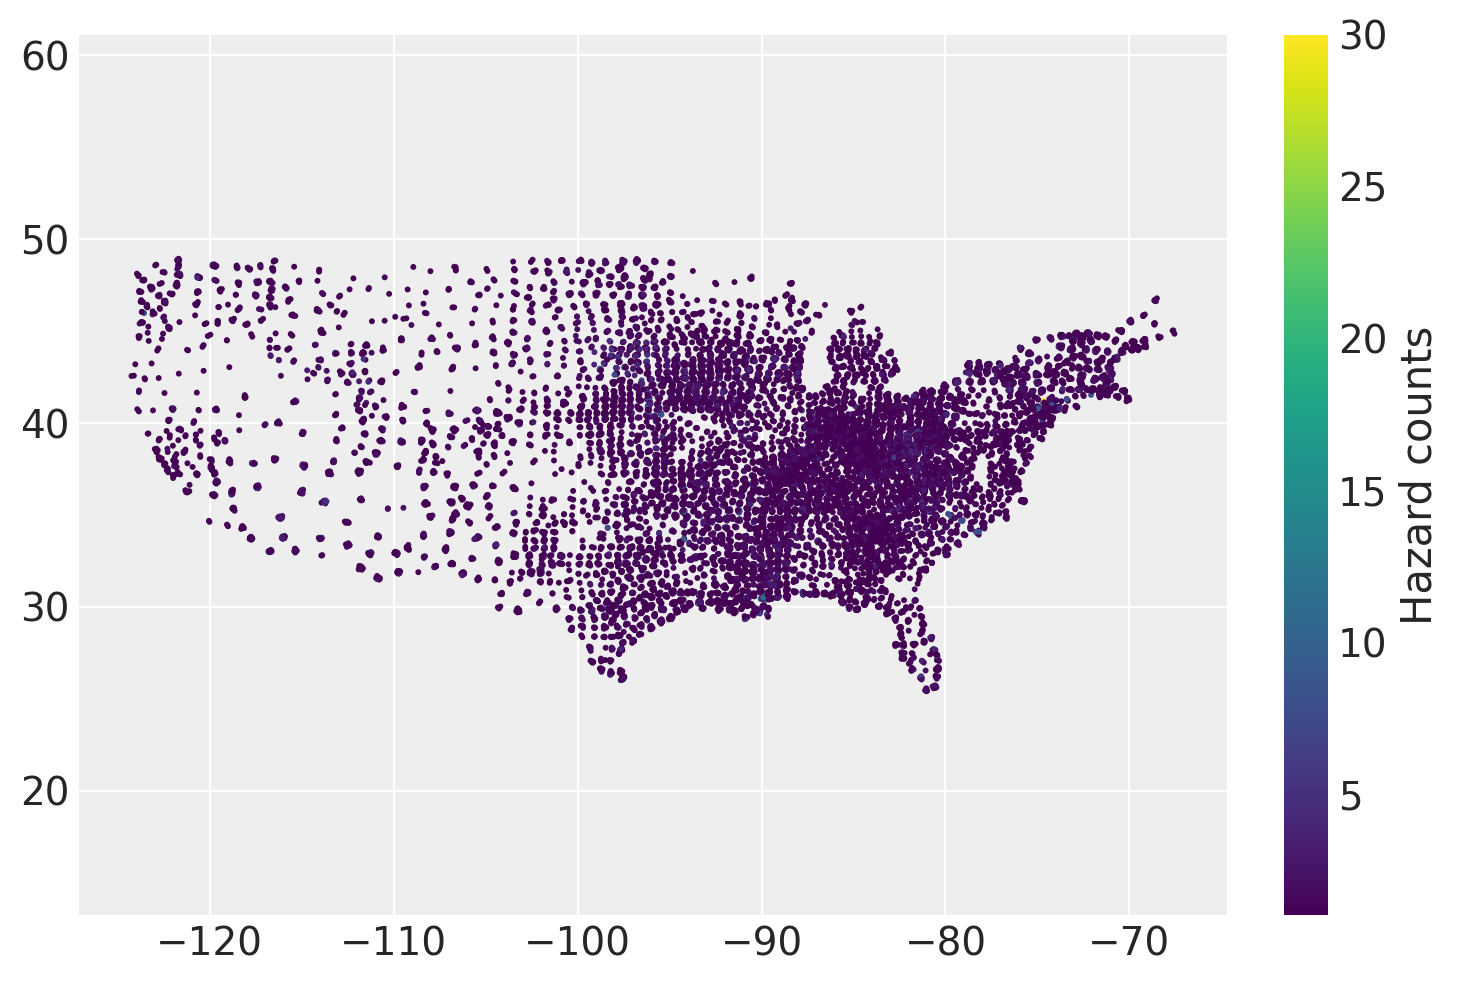

In [23]:
plt.scatter(data_county_coastal_year["x"], data_county_coastal_year["y"], 
            c = data_county_coastal_year["HazardCount"],
            marker='.', s = 5)
plt.colorbar(label="Hazard counts")
plt.axis("equal");


In [24]:

print( np.min( data_county_all_year.x ) )
print( np.max( data_county_all_year.x ) )
print( np.min( data_county_all_year.y ) )
print( np.max( data_county_all_year.y ) )

-124.15629683130643
-67.63741522842712
25.427647058387738
48.82556286679934


In [25]:
data_county_all_year.x

0        -86.642759
1        -86.642759
2        -86.642759
3        -86.642759
4        -86.642759
            ...    
49636   -104.567851
49637   -104.567851
49638   -104.567851
49639   -104.567851
49640   -104.567851
Name: x, Length: 49641, dtype: float64

In [26]:
xy = data_county_coastal_year[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e0
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps


In [86]:
xy[:, 0], xy[:, 1]

(array([ -87.18523751,  -85.94948383,  -87.27980144, ..., -104.15060828,
        -104.22374575, -104.98959594]),
 array([32.86761356, 32.1407561 , 32.11265536, ..., 43.71764378,
        43.89578888, 44.52316802]))

In [85]:

quadrat_x, quadrat_y

(array([-125., -120., -115., -110., -105., -100.,  -95.,  -90.,  -85.,
         -80.,  -75.,  -70.,  -65.]),
 array([20., 25., 30., 35., 40., 45., 50.]))

In [27]:
resolution = 5

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution**2 / 100

cells_x = int(60 / resolution)
cells_y = int(30 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(-125, -65, cells_x + 1)
quadrat_y = np.linspace(20, 50, cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 2.5, quadrat_y[:-1] + 2.5)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)


In [41]:
print( cell_counts.mean(), cell_counts.std() )


231.31944444444446 366.54698146610565


In [42]:
cell_counts

array([   0,    0,    0,  114,   52,  103,    0,    0,   77,  117,   62,
        139,    0,    1,  116,  145,  115,   34,    0,    6,  142,  180,
         83,   42,    0,   39,  274,  153,  206,  123,    2,  258,  566,
        479,  551,  280,    0,  136,  966,  859,  933,  153,    0,   57,
        957, 1419,  660,   80,    7,  169,  684, 1944,  735,   19,    0,
         14,  113,  658,  666,    8,    0,    0,    0,   65,  715,   70,
          0,    0,    0,    1,   78,   30])

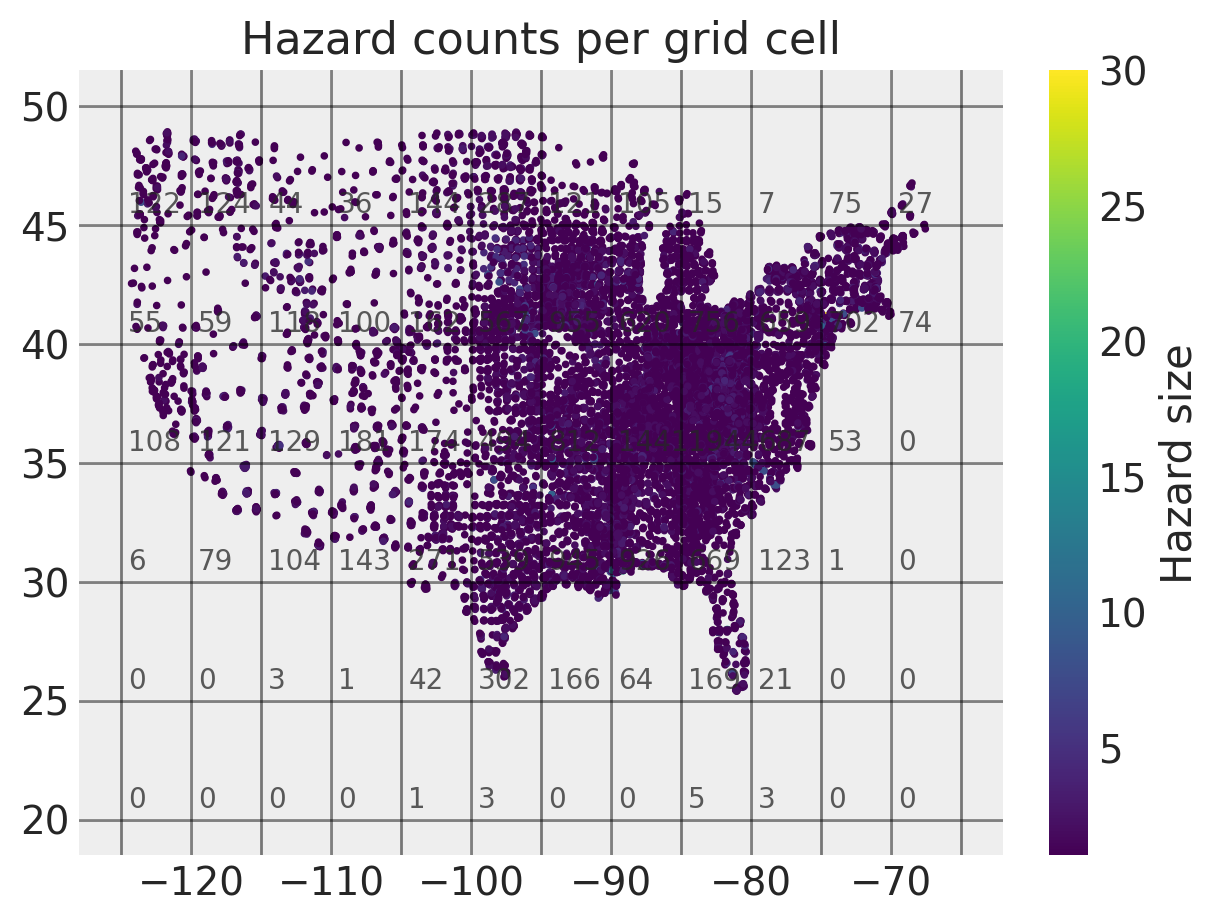

In [28]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data_county_coastal_year["x"], data_county_coastal_year["y"], 
            c= data_county_coastal_year["HazardCount"], s=3)

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Hazard counts per grid cell"), 
plt.colorbar(label="Hazard size");

In [62]:
with pm.Model() as lgcp_model:
    mu  = pm.Normal("mu", mu = 231, sigma = 365)
    rho = pm.Uniform("rho", lower = 1, upper =  231 )
    variance  = pm.InverseGamma("variance", alpha = 1, beta = 1)
    cov_func  = variance * pm.gp.cov.Matern52(2, ls = rho)
    mean_func = pm.gp.mean.Constant(mu)
    

In [63]:
pm.gp.cov.Matern52(2, ls=rho)

In [64]:
with lgcp_model:
    gp = pm.gp.Latent(mean_func = mean_func, cov_func = cov_func)
    log_intensity = gp.prior("log_intensity", X = centroids)
    intensity = pm.math.exp(log_intensity)
    rates     = intensity * area_per_cell
    counts    = pm.Poisson("counts", mu = rates, observed = cell_counts)


In [65]:
log_intensity

log_intensity

In [66]:
with lgcp_model:#   trace = pm.sample(target_accept=0.25, chains=4, return_inferencedata=True)
    trace = pm.sample(100, tune=200, target_accept=0.95, chains=3, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [mu, rho, variance, log_intensity_rotated_]


Sampling 3 chains for 200 tune and 100 draw iterations (600 + 300 draws total) took 824 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [67]:
az.summary(trace, var_names=["mu", "rho"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,227.420,1.168,225.877,228.697,0.647,0.506,3.0,3.0,33150826.14
rho,130.914,26.543,99.161,164.027,14.699,11.498,3.0,3.0,33150826.14


In [68]:
trace.posterior

<xarray.Dataset>
Dimensions:                       (chain: 3, draw: 100,
                                   log_intensity_rotated__dim_0: 72,
                                   log_intensity_dim_0: 72)
Coordinates:
  * chain                         (chain) int64 0 1 2
  * draw                          (draw) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * log_intensity_rotated__dim_0  (log_intensity_rotated__dim_0) int64 0 ... 71
  * log_intensity_dim_0           (log_intensity_dim_0) int64 0 1 2 ... 69 70 71
Data variables:
    mu                            (chain, draw) float64 227.7 227.7 ... 225.9
    log_intensity_rotated_        (chain, draw, log_intensity_rotated__dim_0) float64 ...
    rho                           (chain, draw) float64 164.0 164.0 ... 99.16
    variance                      (chain, draw) float64 611.9 611.9 ... 583.7
    log_intensity                 (chain, draw, log_intensity_dim_0) float64 ...
Attributes:
    created_at:                 2023-10-05T15:27:23.098663
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              824.2184760570526
    tuning_steps:               200

In [29]:
x_new  = np.linspace(-125, -65, 5)
y_new  = np.linspace(20, 50, 5)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

In [30]:
with lgcp_model:
    intensity_new = gp.conditional("log_intensity_new", Xnew = xy_new)
    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"] 
        #keep_size = True
    )
    trace.extend(
        az.from_dict(posterior_predictive = spp_trace, dims = {"log_intensity_new": ["sample"]})
    )
    intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"])

NameError: name 'lgcp_model' is not defined

In [31]:
augmented_coordinates = np.vstack([centroids, data_county_coastal_year[["x", "y"]].values])

In [32]:
n_centroids = centroids.shape[0]

with pm.Model() as mark_model:
    mu  = pm.Normal("mu", mu=231, sigma= 365)
    rho = pm.Uniform("rho", lower= 1, upper=  231 )

    cov_scale = pm.InverseGamma("scale", alpha=1, beta=1)

    cov_func      = cov_scale * pm.gp.cov.Matern52(2, ls=rho)
    mean_func     = pm.gp.mean.Constant(mu)
    intensity_gp  = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = intensity_gp.prior("log_intensity", X=augmented_coordinates)
    intensity     = pm.math.exp(log_intensity)

    rates  = intensity[0:n_centroids] * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

In [81]:
cell_counts

array([   0,    0,    0,  114,   52,  103,    0,    0,   77,  117,   62,
        139,    0,    1,  116,  145,  115,   34,    0,    6,  142,  180,
         83,   42,    0,   39,  274,  153,  206,  123,    2,  258,  566,
        479,  551,  280,    0,  136,  966,  859,  933,  153,    0,   57,
        957, 1419,  660,   80,    7,  169,  684, 1944,  735,   19,    0,
         14,  113,  658,  666,    8,    0,    0,    0,   65,  715,   70,
          0,    0,    0,    1,   78,   30])

In [82]:
n_centroids


72

In [33]:
intensity[n_centroids::]
n = data_county_coastal_year.shape[0]


In [34]:
with mark_model:
    alpha  = pm.Normal("alpha", sigma=10.0)
    beta   = pm.Normal("beta", sigma=5)
    eps_sd = pm.HalfCauchy("eps_sd", beta=1.0)
    marks  = pm.Normal(
        "HazardCount",
        mu    = alpha + beta * intensity[n_centroids::],
        sigma = eps_sd,
        shape = n,
        observed = data_county_coastal_year["HazardCount"].values,
    )

In [35]:
with mark_model:
    trace = pm.sample(100, tune=200, target_accept=0.95, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, rho, scale, log_intensity_rotated_, alpha, beta, eps_sd]


In [ ]:
az.summary(trace, var_names=["alpha", "beta"])